In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.layers import Dense,Flatten , Rescaling
from keras.models import Sequential
import os
import cv2


# Loading image

In [2]:
img_array = []
label_array = []

directory = 'Chess_formatted'

for _classname in sorted(os.listdir(directory)):
    for _name in sorted(os.listdir(directory + '/' + _classname)):
        path = directory + '/' + str(_classname) + '/' + str(_name)

        # Convert color and resize color
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        img = img.astype('float32')

        img_array.append(np.array(img))
        label_array.append(_classname)

img_array = np.array(img_array)
label_array = np.array(label_array)

# Split Train Validate and Test

In [3]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(img_array, label_array, test_size=0.2, random_state=7)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=7, )


In [4]:
# string labels to int

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)
val_y = le.fit_transform(val_y)


# Data Augmentation

In [ ]:

data_augmentation = Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Modelling

In [ ]:
def make_model(input_shape, num_classes):

    mobileNet = keras.applications.MobileNet(weights='imagenet', # Pretrain
                                    include_top=False, 
                                    input_shape=(224, 224,3),)

    inputs = keras.Input(shape=input_shape)
    x = Rescaling(1.0 / 255)(inputs) # Normalize
    x = mobileNet(x)
    
    x = Flatten()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(6, activation = 'softmax')(x)
    
    model = keras.Model(inputs, x)
    
    return model

In [ ]:
model = make_model((224,224,3), 6)

17235968/17225924 [==============================] - 4s 0us/step


# Training Model

In [ ]:
epochs = 50
callback = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True,)
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
    train_x, train_y, epochs=epochs,callbacks=callback,  validation_data=(val_x, val_y))


# Evaluation

In [129]:
pred = model.predict(test_x)
pred = np.argmax(pred, axis=1)


4/4 [==============================] - 9s 1s/step


In [130]:
def decodeLabel(label):
    lis = label.tolist()
    for i in range(len(lis)):
        if lis[i] == 0:
            lis[i] = 'Bishop'
        elif lis[i] == 1:
            lis[i] = 'King'
        elif lis[i] == 2:
            lis[i] = 'Knight'
        elif lis[i] == 3:
            lis[i] = 'Pawn'
        elif lis[i] == 4:
            lis[i] = 'Queen'
        elif lis[i] == 5:
            lis[i] = 'Rook'

    return np.array(lis)


In [131]:
pred = decodeLabel(pred)
test_y = decodeLabel(test_y)

In [132]:
from sklearn.metrics import accuracy_score

score= accuracy_score(test_y, pred)
print(score)

0.7297297297297297


In [133]:
label = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']


In [134]:
from sklearn.metrics import classification_report

report = classification_report(test_y ,pred ,target_names=label)
print(report)

              precision    recall  f1-score   support

      Bishop       1.00      0.55      0.71        20
        King       0.46      0.87      0.60        15
      Knight       0.76      0.95      0.84        20
        Pawn       1.00      0.70      0.82        23
       Queen       0.62      0.53      0.57        15
        Rook       0.78      0.78      0.78        18

    accuracy                           0.73       111
   macro avg       0.77      0.73      0.72       111
weighted avg       0.80      0.73      0.74       111



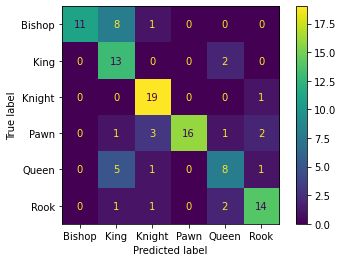

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)

disp_cm.plot()
plt.show()

# Plot Correct and Incorrect prediction

<ipython-input-136-bf884bacaad9>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(test_x)*score//10+1,10,i)


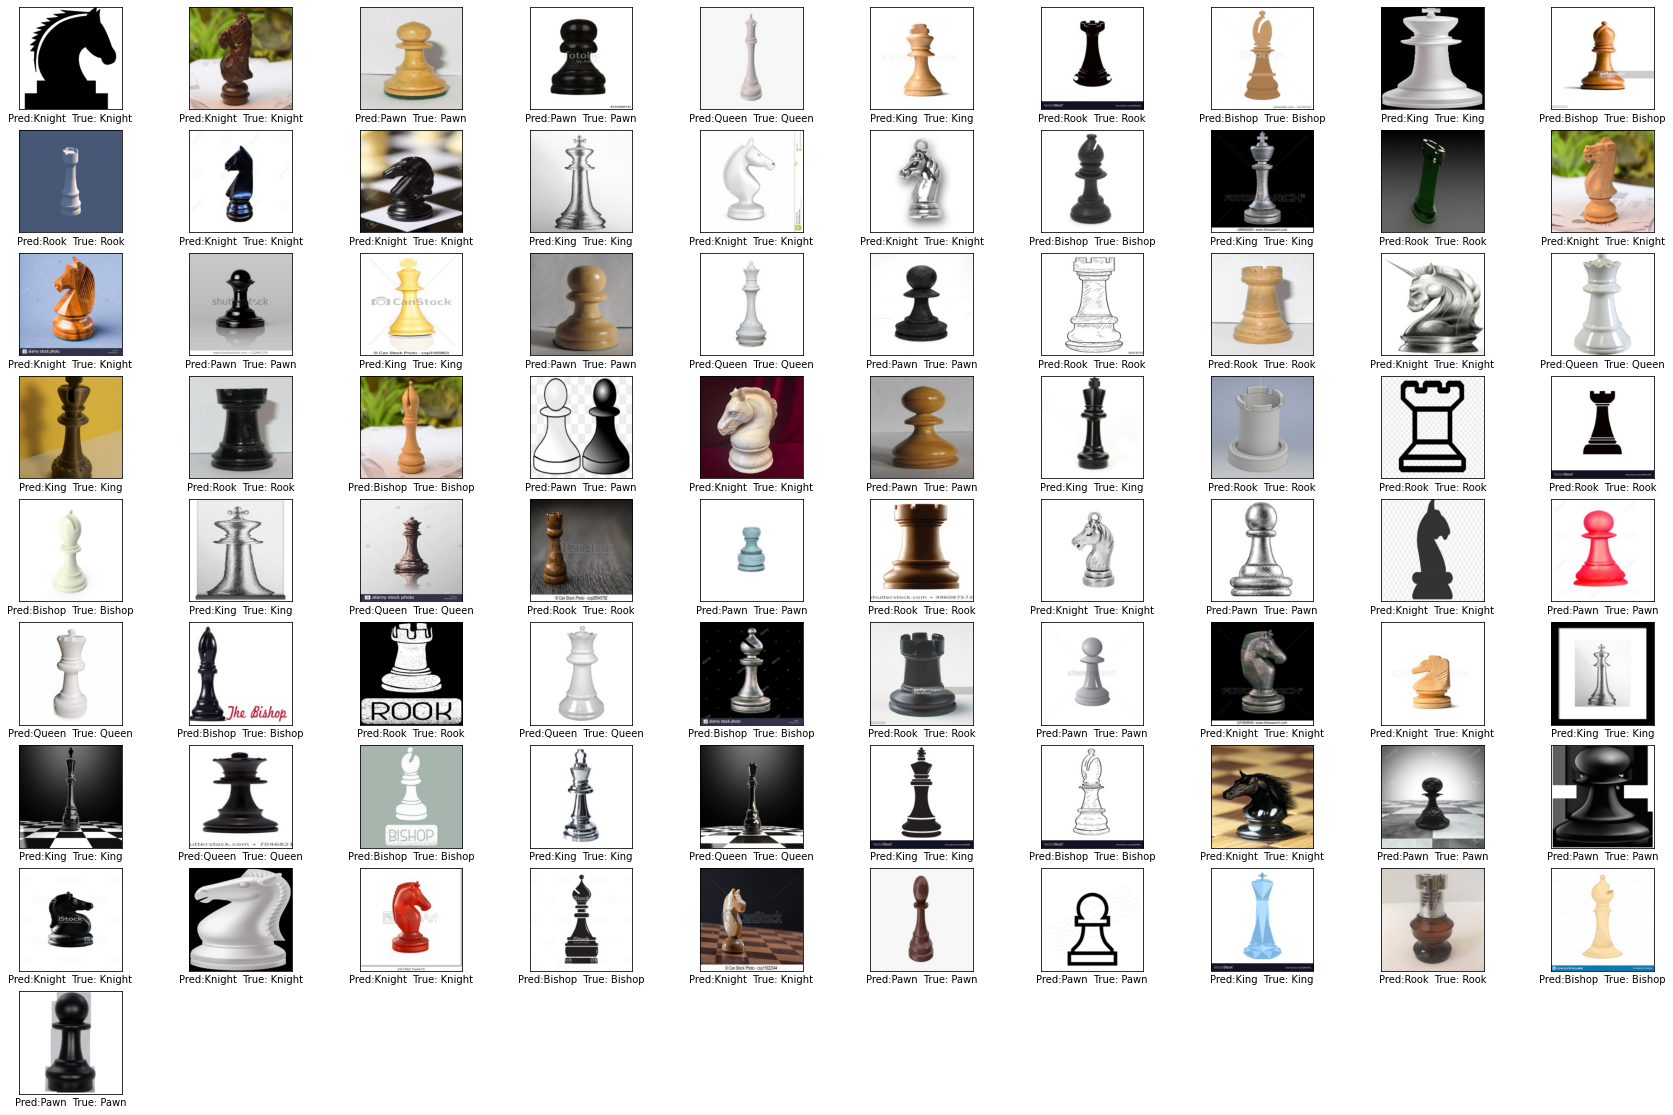

In [136]:
# plot true img
plt.figure(figsize=(30,20),facecolor='white',)
i = 1
for idx, input, prediction, label in zip(enumerate(test_x), test_x, pred, test_y):

    if prediction == label:

        plt.subplot(len(test_x)*score//10+1,10,i)
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(input.astype(np.uint8))
        plt.xlabel('Pred:'+ str(prediction)+'  True: '+ str(label), )
        i += 1

<ipython-input-137-7dc7160c4fe7>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(test_x)*(1-score)//10+1,10,i)


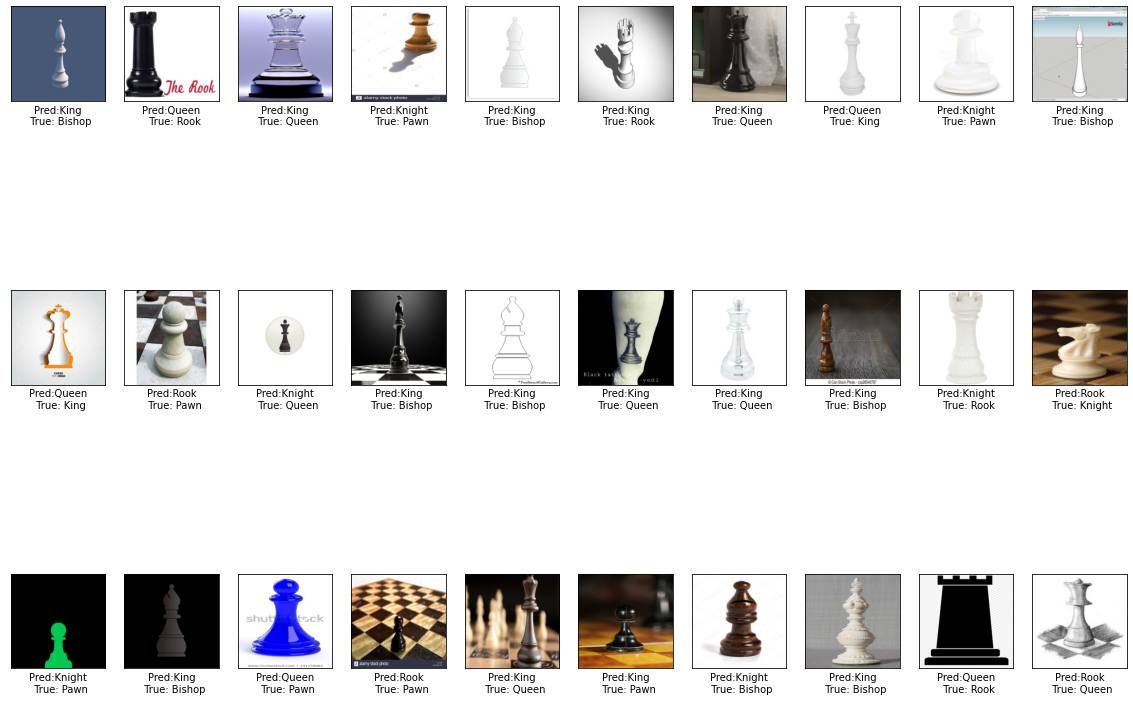

In [137]:
# plot true img
plt.figure(figsize=(20,20),facecolor='white', )
i = 1
for idx, input, prediction, label in zip(enumerate(test_x), test_x, pred, test_y):

    if prediction != label:

        plt.subplot(len(test_x)*(1-score)//10+1,10,i)
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(input.astype(np.uint8))
        plt.xlabel('Pred:'+ str(prediction)+  '\n'+'  True: '+ str(label), )
        i += 1


# Single Image Test

In [138]:
def predImg(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = img.reshape(1,224,224,3)

    pred = model.predict(img)
    pred = np.argmax(pred, axis=1)

    return 'Predict: '+decodeLabel(pred)[0]
    
path = ''

predImg(path)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
